In [177]:
import warnings

import h2o
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from h2o.automl import H2OAutoML
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

warnings.filterwarnings("ignore")

In [147]:
# Carga de datos
df_survey = pd.read_pickle(filepath_or_buffer="data/df_survey.pkl")
y = "covid19"
ignore = ["covid19"]
x = list(set(df_survey.columns) - set(ignore))

In [148]:
# Define the numeric and categorical features
numeric_features = [
    "id_bio_age",
    "id_bio_weight",
    "id_bio_height",
    "id_mat_18p_house_members",
    "id_mat_total_house_members",
]
categorical_features = list(set(x) - set(numeric_features))

# scaler = StandardScaler()
# df_survey_imputed_num = pd.DataFrame(
#     scaler.fit_transform(df_survey[x]), columns=x)
# imputer = KNNImputer(n_neighbors=10)
# df_survey_imputed_num = pd.DataFrame(
#     imputer.fit_transform(df_survey[numeric_features]), columns=numeric_features
# )
# df_survey_imputed_num = df_survey_imputed_num[numeric_features]
# df_survey_imputed_num = pd.DataFrame(
#     imputer.fit_transform(df_survey_imputed_num), columns=df_survey_imputed_num.columns
# )

imputer = SimpleImputer(strategy="mean")
df_survey_imputed_num = pd.DataFrame(
    imputer.fit_transform(df_survey[numeric_features]), columns=numeric_features
)
df_survey_imputed_num = df_survey_imputed_num[numeric_features]

# Define the transformers for numeric and categorical features
# numeric_transformer = Pipeline(
#     # steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
#     steps=[("imputer", KNNImputer(n_neighbors=5)), ("scaler", StandardScaler())]
# )

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ]
)

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        # ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Fit and transform the data
df_survey_imputed_cat = preprocessor.fit_transform(df_survey[x])

df_survey_imputed = pd.DataFrame(
    np.concatenate([df_survey_imputed_num, df_survey_imputed_cat], axis=1),
    columns=numeric_features + categorical_features,
)

df_survey_imputed.head()

,id_bio_age,id_bio_weight,id_bio_height,id_mat_18p_house_members,id_mat_total_house_members,id_psy_anxiety_sympt,id_bio_disability,id_psy_vacc_myths,sd_eth_is_costa_rican,sd_occ_current_job,...,id_beh_risk_personal,id_bio_out_bubble_contag,sd_cul_religion,id_beh_percep_severity,id_bio_comorbidities,id_bio_vacc_status,id_bio_gender,sd_edu_level,id_bio_death_covid,sd_inc_income_problems
0,52.0,83.0,178.0,3.0,3.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,68.0,68.0,171.0,3.0,3.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,2.0,1.0,0.0,1.0,2.0,0.0,0.0
2,36.0,90.0,171.0,2.0,3.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
3,78.0,57.0,150.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0
4,20.0,78.0,180.0,5.0,5.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


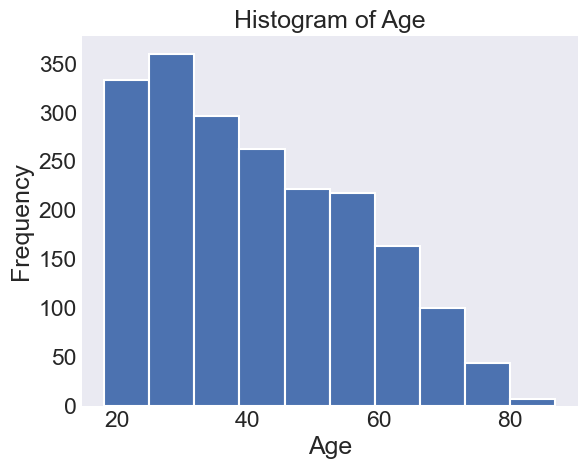

In [149]:
plt.hist(df_survey_imputed.id_bio_age)
plt.title("Histogram of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

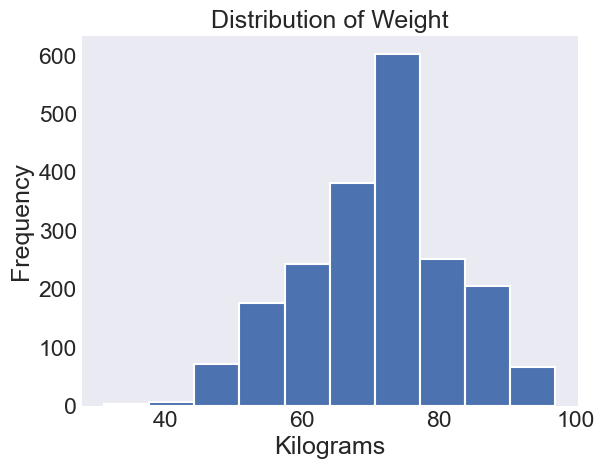

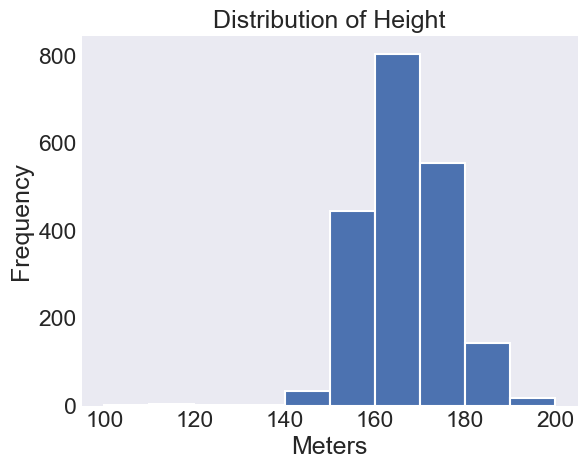

Text(0.5, 1.0, 'Distribution of BMI')

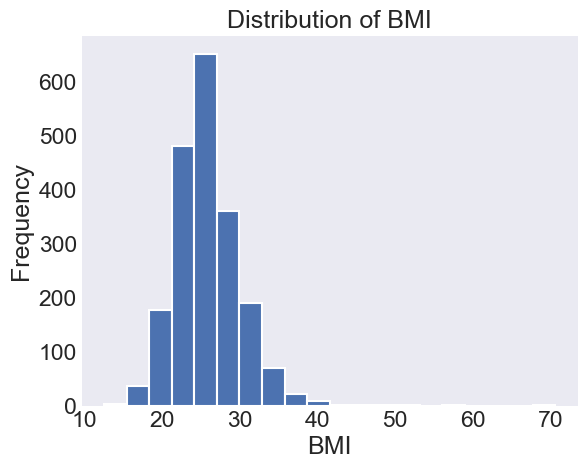

In [150]:
# Plot the distribution of weight
plt.hist(df_survey_imputed.id_bio_weight)
plt.xlabel("Kilograms")
plt.ylabel("Frequency")
plt.title("Distribution of Weight")
plt.show()

# Plot the distribution of height
plt.hist(df_survey_imputed.id_bio_height)
plt.xlabel("Meters")
plt.ylabel("Frequency")
plt.title("Distribution of Height")
plt.show()

# Calculate the BMI and plot its distribution
df_survey_imputed["id_bio_bmi"] = (
    df_survey_imputed["id_bio_weight"] /
    (df_survey_imputed["id_bio_height"] / 100) ** 2
)
plt.hist(df_survey_imputed.id_bio_bmi, bins=20)
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.title("Distribution of BMI")


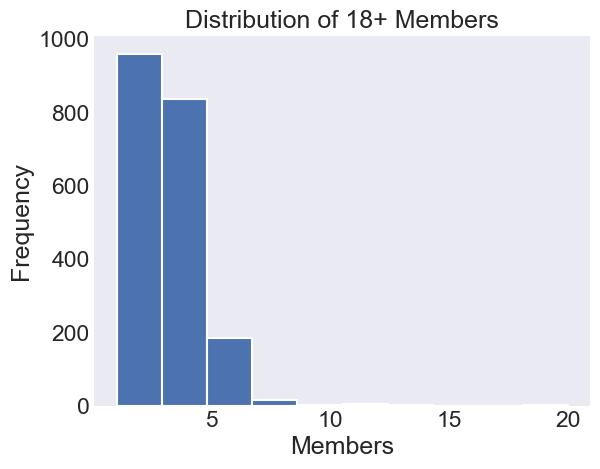

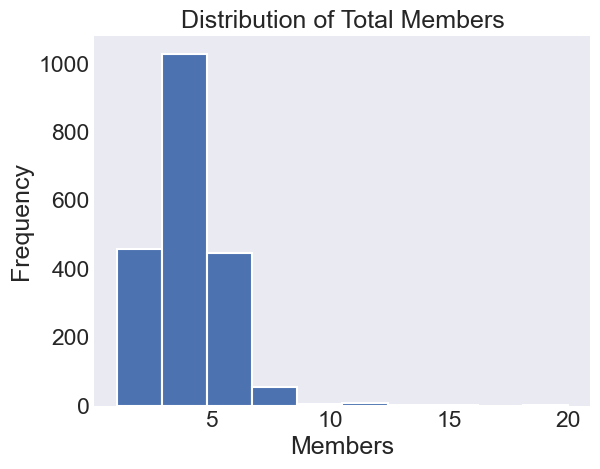

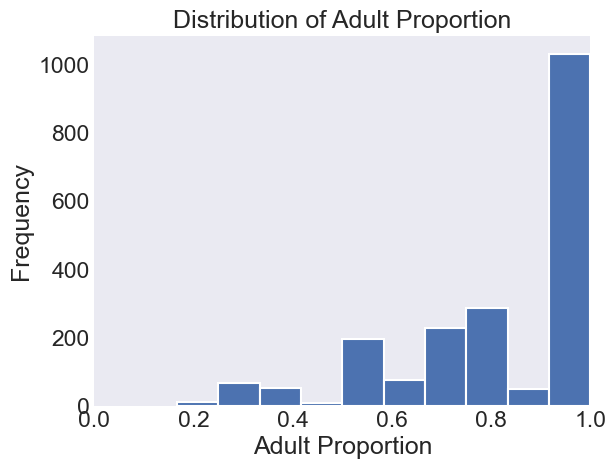

In [151]:
plt.hist(df_survey_imputed.id_mat_18p_house_members)
plt.xlabel("Members")
plt.ylabel("Frequency")
plt.title("Distribution of 18+ Members")
plt.show()

plt.hist(df_survey_imputed.id_mat_total_house_members)
plt.xlabel("Members")
plt.ylabel("Frequency")
plt.title("Distribution of Total Members")
plt.show()

df_survey_imputed["id_mat_adult_prop"] = (
    df_survey_imputed["id_mat_18p_house_members"]
    / df_survey_imputed["id_mat_total_house_members"]
)

df_survey_imputed = df_survey_imputed.assign(
    id_mat_adult_prop=lambda df: np.where(
        df["id_mat_adult_prop"] > 1, 1, df["id_mat_adult_prop"]
    )
)

plt.hist(df_survey_imputed.id_mat_adult_prop, bins=10)
plt.xlabel("Adult Proportion")
plt.ylabel("Frequency")
plt.xlim(0, 1)
plt.title("Distribution of Adult Proportion")
plt.show()

In [152]:
# Clean unused variables

df_survey_imputed = df_survey_imputed.drop(
    columns=[
        "id_bio_weight",
        "id_bio_height",
        "id_mat_18p_house_members",
        "id_mat_total_house_members",
    ]
)
df_survey_imputed.head()

,id_bio_age,id_psy_anxiety_sympt,id_bio_disability,id_psy_vacc_myths,sd_eth_is_costa_rican,sd_occ_current_job,id_beh_risk_others,id_bio_bubble_contag,id_beh_physical_act,sd_cul_holiday_season,...,sd_cul_religion,id_beh_percep_severity,id_bio_comorbidities,id_bio_vacc_status,id_bio_gender,sd_edu_level,id_bio_death_covid,sd_inc_income_problems,id_bio_bmi,id_mat_adult_prop
0,52.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,26.196187,1.000000
1,68.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,...,1.0,2.0,1.0,0.0,1.0,2.0,0.0,0.0,23.255019,1.000000
2,36.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,30.778701,0.666667
3,78.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,...,1.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,25.333333,1.000000
4,20.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,24.074074,1.000000


In [153]:
X_train, X_test, y_train, y_test = train_test_split(
    df_survey_imputed,
    df_survey[y],
    test_size=0.2,
    random_state=40,
    stratify=df_survey[y],
)


print("#" * 5 + " Split sample " + "#" * 5)
print("train:%d, test:%d" % (len(y_train.index), len(y_test.index)))
print("#" * 5 + " Distribution Train Sample " + "#" * 5)
print(y_train.value_counts() / len(y_train))
print("#" * 5 + " Distribution Test Sample " + "#" * 5)
print(y_test.value_counts() / len(y_test))

train = pd.concat([y_train, X_train], axis=1)
test = pd.concat([y_test, X_test], axis=1)


##### Split sample #####
train:1602, test:401
##### Distribution Train Sample #####
covid19
False    0.730961
True     0.269039
Name: count, dtype: float64
##### Distribution Test Sample #####
covid19
False    0.730673
True     0.269327
Name: count, dtype: float64


In [180]:
df_survey_imputed.columns.sort_values().tolist()


['id_beh_percep_contag',
 'id_beh_percep_severity',
 'id_beh_physical_act',
 'id_beh_risk_others',
 'id_beh_risk_personal',
 'id_bio_age',
 'id_bio_bmi',
 'id_bio_bubble_contag',
 'id_bio_comorbidities',
 'id_bio_death_covid',
 'id_bio_disability',
 'id_bio_gender',
 'id_bio_out_bubble_contag',
 'id_bio_vacc_status',
 'id_mat_adult_prop',
 'id_psy_anxiety_sympt',
 'id_psy_vacc_myths',
 'sd_cul_holiday_season',
 'sd_cul_religion',
 'sd_edu_level',
 'sd_eth_is_costa_rican',
 'sd_inc_income_level',
 'sd_inc_income_problems',
 'sd_occ_current_job']

In [190]:
categorical_features

['id_psy_anxiety_sympt',
 'id_bio_disability',
 'id_psy_vacc_myths',
 'sd_eth_is_costa_rican',
 'sd_occ_current_job',
 'id_beh_risk_others',
 'id_bio_bubble_contag',
 'id_beh_physical_act',
 'sd_cul_holiday_season',
 'sd_inc_income_level',
 'id_beh_percep_contag',
 'id_beh_risk_personal',
 'id_bio_out_bubble_contag',
 'sd_cul_religion',
 'id_beh_percep_severity',
 'id_bio_comorbidities',
 'id_bio_vacc_status',
 'id_bio_gender',
 'sd_edu_level',
 'id_bio_death_covid',
 'sd_inc_income_problems']

In [224]:
import skimpy

bool_variables = [
    "id_bio_bubble_contag",
    "id_bio_death_covid",
    "id_bio_vacc_status",
    "sd_inc_income_problems",
    "id_bio_gender",
    "sd_occ_current_job",
    "sd_eth_is_costa_rican",
    "id_bio_comorbidities",
    "sd_cul_religion",
    "id_bio_disability",
]
cat012_variables = list(
    set(
        [
            "id_psy_anxiety_sympt",
            "id_bio_disability",
            "id_psy_vacc_myths",
            "sd_eth_is_costa_rican",
            "sd_occ_current_job",
            "id_beh_risk_others",
            "id_bio_bubble_contag",
            "id_beh_physical_act",
            "sd_cul_holiday_season",
            "sd_inc_income_level",
            "id_beh_percep_contag",
            "id_beh_risk_personal",
            "id_bio_out_bubble_contag",
            "sd_cul_religion",
            "id_beh_percep_severity",
            "id_bio_comorbidities",
            "id_bio_vacc_status",
            "id_bio_gender",
            "sd_edu_level",
            "id_bio_death_covid",
            "sd_inc_income_problems",
        ]
    )
    - set(bool_variables)
)
df = df_survey_imputed.copy()
df[bool_variables] = df[bool_variables].astype("bool")
cat_012_ord = pd.CategoricalDtype(categories=[0, 1, 2], ordered=True)
df[cat012_variables] = df[cat012_variables].astype("category")


# Frequency tables for each categorical feature
for column in df.select_dtypes(include=["bool", "category"]).columns:
    display(
        pd.crosstab(index=df[column], columns="% observations", normalize="columns").T
        * 100
    )
    display(pd.crosstab(index=df[column], columns="count").T)

display(df.describe().T)

id_psy_anxiety_sympt,0.0,1.0,2.0
col_0,,,
% observations,99.151273,0.698952,0.149775


id_psy_anxiety_sympt,0.0,1.0,2.0
col_0,,,
count,1986,14,3


id_bio_disability,False,True
col_0,,
% observations,91.712431,8.287569


id_bio_disability,False,True
col_0,,
count,1837,166


id_psy_vacc_myths,0.0,1.0,2.0
col_0,,,
% observations,93.310035,3.844234,2.845731


id_psy_vacc_myths,0.0,1.0,2.0
col_0,,,
count,1869,77,57


sd_eth_is_costa_rican,False,True
col_0,,
% observations,11.832252,88.167748


sd_eth_is_costa_rican,False,True
col_0,,
count,237,1766


sd_occ_current_job,False,True
col_0,,
% observations,31.352971,68.647029


sd_occ_current_job,False,True
col_0,,
count,628,1375


id_beh_risk_others,0.0,1.0,2.0
col_0,,,
% observations,82.376435,13.330005,4.29356


id_beh_risk_others,0.0,1.0,2.0
col_0,,,
count,1650,267,86


id_bio_bubble_contag,False,True
col_0,,
% observations,63.654518,36.345482


id_bio_bubble_contag,False,True
col_0,,
count,1275,728


id_beh_physical_act,0.0,1.0,2.0
col_0,,,
% observations,40.639041,48.82676,10.534199


id_beh_physical_act,0.0,1.0,2.0
col_0,,,
count,814,978,211


sd_cul_holiday_season,0.0,1.0,2.0
col_0,,,
% observations,4.29356,10.434348,85.272092


sd_cul_holiday_season,0.0,1.0,2.0
col_0,,,
count,86,209,1708


sd_inc_income_level,0.0,1.0,2.0
col_0,,,
% observations,18.322516,27.808288,53.869196


sd_inc_income_level,0.0,1.0,2.0
col_0,,,
count,367,557,1079


id_beh_percep_contag,0.0,1.0,2.0
col_0,,,
% observations,25.312032,35.297054,39.390914


id_beh_percep_contag,0.0,1.0,2.0
col_0,,,
count,507,707,789


id_beh_risk_personal,0.0,1.0,2.0
col_0,,,
% observations,95.007489,4.093859,0.898652


id_beh_risk_personal,0.0,1.0,2.0
col_0,,,
count,1903,82,18


id_bio_out_bubble_contag,0.0,1.0
col_0,,
% observations,24.213679,75.786321


id_bio_out_bubble_contag,0.0,1.0
col_0,,
count,485,1518


sd_cul_religion,False,True
col_0,,
% observations,49.575637,50.424363


sd_cul_religion,False,True
col_0,,
count,993,1010


id_beh_percep_severity,0.0,1.0,2.0
col_0,,,
% observations,31.303045,30.654019,38.042936


id_beh_percep_severity,0.0,1.0,2.0
col_0,,,
count,627,614,762


id_bio_comorbidities,False,True
col_0,,
% observations,60.858712,39.141288


id_bio_comorbidities,False,True
col_0,,
count,1219,784


id_bio_vacc_status,False,True
col_0,,
% observations,91.712431,8.287569


id_bio_vacc_status,False,True
col_0,,
count,1837,166


id_bio_gender,False,True
col_0,,
% observations,53.719421,46.280579


id_bio_gender,False,True
col_0,,
count,1076,927


sd_edu_level,0.0,1.0,2.0
col_0,,,
% observations,38.841737,38.142786,23.015477


sd_edu_level,0.0,1.0,2.0
col_0,,,
count,778,764,461


id_bio_death_covid,False,True
col_0,,
% observations,73.24014,26.75986


id_bio_death_covid,False,True
col_0,,
count,1467,536


sd_inc_income_problems,False,True
col_0,,
% observations,84.123814,15.876186


sd_inc_income_problems,False,True
col_0,,
count,1685,318


,count,mean,std,min,25%,50%,75%,max
id_bio_age,2003.0,41.170245,15.750727,18.000000,28.000000,39.000000,53.000000,87.000000
id_bio_bmi,2003.0,25.833732,4.291258,12.576575,23.089581,25.510204,28.040378,70.633628
id_mat_adult_prop,2003.0,0.817745,0.217226,0.166667,0.666667,1.000000,1.000000,1.000000


In [205]:
df.id_beh_percep_severity


CategoricalDtype(categories=[0, 1, 2], ordered=True)

In [155]:
# Inicializar h2o
# h2o.cluster().shutdown()

h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,8 hours 3 mins
H2O_cluster_timezone:,America/Costa_Rica
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,1 month and 18 days
H2O_cluster_name:,H2O_from_python_maikol_w2qm5q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.590 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [156]:
train.columns

Index(['covid19', 'id_bio_age', 'id_psy_anxiety_sympt', 'id_bio_disability',
       'id_psy_vacc_myths', 'sd_eth_is_costa_rican', 'sd_occ_current_job',
       'id_beh_risk_others', 'id_bio_bubble_contag', 'id_beh_physical_act',
       'sd_cul_holiday_season', 'sd_inc_income_level', 'id_beh_percep_contag',
       'id_beh_risk_personal', 'id_bio_out_bubble_contag', 'sd_cul_religion',
       'id_beh_percep_severity', 'id_bio_comorbidities', 'id_bio_vacc_status',
       'id_bio_gender', 'sd_edu_level', 'id_bio_death_covid',
       'sd_inc_income_problems', 'id_bio_bmi', 'id_mat_adult_prop'],
      dtype='object')

In [157]:
# Convertir a h2o
col_types = {
    "covid19": "enum",
    "id_beh_percep_contag": "enum",
    "id_beh_percep_severity": "enum",
    "id_bio_bubble_contag": "enum",
    "id_bio_out_bubble_contag": "enum",
    "id_bio_death_covid": "enum",
    "id_beh_risk_personal": "enum",
    "id_beh_risk_others": "enum",
    "id_beh_physical_act": "enum",
    "id_psy_vacc_myths": "enum",
    "id_bio_vacc_status": "enum",
    "id_psy_anxiety_sympt": "enum",
    "sd_inc_income_problems": "enum",
    "sd_inc_income_level": "enum",
    "sd_cul_holiday_season": "enum",
    "id_bio_gender": "enum",
    "id_bio_age": "numeric",
    "id_bio_bmi": "numeric",
    #    "id_bio_weight": "numeric",
    #   "id_bio_height": "numeric",
    "sd_edu_level": "enum",
    "sd_occ_current_job": "enum",
    "sd_eth_is_costa_rican": "enum",
    "id_bio_comorbidities": "enum",
    "sd_cul_religion": "enum",
    "id_bio_disability": "enum",
    "id_mat_adult_prop": "numeric",
    # "id_mat_18_plus_household_members": "numeric",
    # "id_mat_total_household_members": "numeric",
}

train_h2o = h2o.H2OFrame(train, column_types=col_types)
test_h2o = h2o.H2OFrame(test, column_types=col_types)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [158]:
train_h2o.types

{'covid19': 'enum',
 'id_bio_age': 'int',
 'id_psy_anxiety_sympt': 'enum',
 'id_bio_disability': 'enum',
 'id_psy_vacc_myths': 'enum',
 'sd_eth_is_costa_rican': 'enum',
 'sd_occ_current_job': 'enum',
 'id_beh_risk_others': 'enum',
 'id_bio_bubble_contag': 'enum',
 'id_beh_physical_act': 'enum',
 'sd_cul_holiday_season': 'enum',
 'sd_inc_income_level': 'enum',
 'id_beh_percep_contag': 'enum',
 'id_beh_risk_personal': 'enum',
 'id_bio_out_bubble_contag': 'enum',
 'sd_cul_religion': 'enum',
 'id_beh_percep_severity': 'enum',
 'id_bio_comorbidities': 'enum',
 'id_bio_vacc_status': 'enum',
 'id_bio_gender': 'enum',
 'sd_edu_level': 'enum',
 'id_bio_death_covid': 'enum',
 'sd_inc_income_problems': 'enum',
 'id_bio_bmi': 'real',
 'id_mat_adult_prop': 'real'}

In [159]:
max_models = 1000
excluded_algos = ["StackedEnsemble", "DeepLearning"]

# Definir modelo y entrenar
aml = H2OAutoML(
    # nfolds=10,
    nfolds=-1,
    max_models=max_models,
    max_runtime_secs=3600,
    seed=42,
    stopping_metric="aucpr",
    sort_metric="aucpr",
    balance_classes=False,
    exclude_algos=excluded_algos,
)
aml.train(y=y, training_frame=train_h2o)
h2o.save_model(
    aml.leader,
    path="models/",
    force=True,
    filename="aml_leader_model",
    export_cross_validation_predictions=True,
)


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


'/Users/maikol/OneDrive/home/documents/2023/2023_03_paper_triageml_cr2021/Paper-COVID-MLTriage-CR2021/models/aml_leader_model'

In [160]:
if "aml" in locals() and isinstance(aml, h2o.automl.autoh2o.H2OAutoML):
    aml_leader = aml.leader
else:
    aml_leader = h2o.load_model("models/aml_leader_model")

In [161]:
aml_leader


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_3_20231010_174317_model_622


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    30                 30                          4271                   3            6            4.03333       4             9             6.7

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.14400471199006448
RMSE: 0.379479527761465
LogLoss: 0.45182098056672976
Mean Per-Class Error: 0.2163102510199108
AUC: 0.8370490646937494
AUCPR: 0.6375474490509433
Gini: 0.6740981293874988

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.356188580446631
       False    True    Error    Rate
-----  -------  ------  -------  --------------
False  985      186     0.1588   (186.0/1171.0)
True   118      313     0.2738   (118.0/431.0)
Total  1103     499     0.1898   (304.0/1602.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.356189     0.673118  177
max f2                       0.213792     0.738046  256
max f0point5                 0.372378     0.646982  165
max accuracy                 0.372378     0.810861  165
max precision                0.594905     0.826923  25
max recall                   0.102593     1         395
max specificity              0.669776     0.999146  0
max absolute_mcc             0.356189     0.543316  177
max min_per_class_accuracy   0.266105     0.777262  221
max mean_per_class_accuracy  0.324648     0.786815  196
max tns                      0.669776     1170      0
max fns                      0.669776     430       0
max fps                      0.0910873    1171      399
max tps                      0.102593     431       395
max tnr                      0.669776     0.999146  0
max fnr                      0.669776     0.99768   0
max fpr                      0.0910873    1         399
max tpr                      0.102593     1         395

Gains/Lift Table: Avg response rate: 26.90 %, avg score: 27.07 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0106117                   0.624503           2.62372   2.62372            0.705882         0.647033  0.705882                    0.647033            0.0278422       0.0278422                  162.372   162.372            0.0235724
2        0.0205993                   0.611783           3.25232   2.9285             0.875            0.616982  0.787879                    0.632462            0.0324826       0.0603248                  225.232   192.85             0.054347
3        0.0305868                   0.595253           3.25232   3.03423            0.875            0.604419  0.816327                    0.623305            0.0324826       0.0928074                  225.232   203.423            0.0851217
4        0.0405743                   0.585958           2.55539   2.91637            0.6875           0.591732  0.784615                    0.615534            0.025522        0.118329                   155.539   191.637            0.106374
5        0.0505618                   0.578444           2.55539   2.84506            0.6875           0.583424  0.76543

In [162]:
aml_leader.algo

'gbm'

In [163]:
aml_leader.save_model_details(
    path="models/", force=True, filename="aml_leader_model_details"
)


'/Users/maikol/OneDrive/home/documents/2023/2023_03_paper_triageml_cr2021/Paper-COVID-MLTriage-CR2021/models/aml_leader_model_details'

In [164]:
aml_leader.summary()

,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,30.0,30.0,4271.0,3.0,6.0,4.0333333,4.0,9.0,6.7


In [165]:
# Performance del modelo

perf = aml_leader.model_performance(test_data=test_h2o)
prevalence = sum(df_survey.covid19) / len(df_survey)
threshold = perf.F1()[0][0]
sensitivity = perf.recall(thresholds=[threshold])[0][1]
specificity = perf.specificity(thresholds=[threshold])[0][1]
F1 = perf.F1(thresholds=[threshold])[0][1]
AUC = perf.auc()
AUC_PR = perf.aucpr()
precision = perf.precision(thresholds=[threshold])[0][1]
accuracy = perf.accuracy(thresholds=[threshold])[0][1]


print("Prevalence", prevalence)
print("Threshold", threshold)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Accuracy:", accuracy)
print("F1:", F1)
print("AUC:", AUC)
print("AUC_PR:", AUC_PR)
print(perf.confusion_matrix(thresholds=[threshold]))


Prevalence 0.2690963554667998
Threshold 0.303679453082953
Sensitivity: 0.7962962962962963
Specificity: 0.7610921501706485
Precision: 0.5512820512820513
Accuracy: 0.770573566084788
F1: 0.6515151515151515
AUC: 0.8035646568069776
AUC_PR: 0.5400904522113642
Confusion Matrix (Act/Pred) @ threshold = 0.303679453082953
       False    True    Error    Rate
-----  -------  ------  -------  ------------
False  223      70      0.2389   (70.0/293.0)
True   22       86      0.2037   (22.0/108.0)
Total  245      156     0.2294   (92.0/401.0)


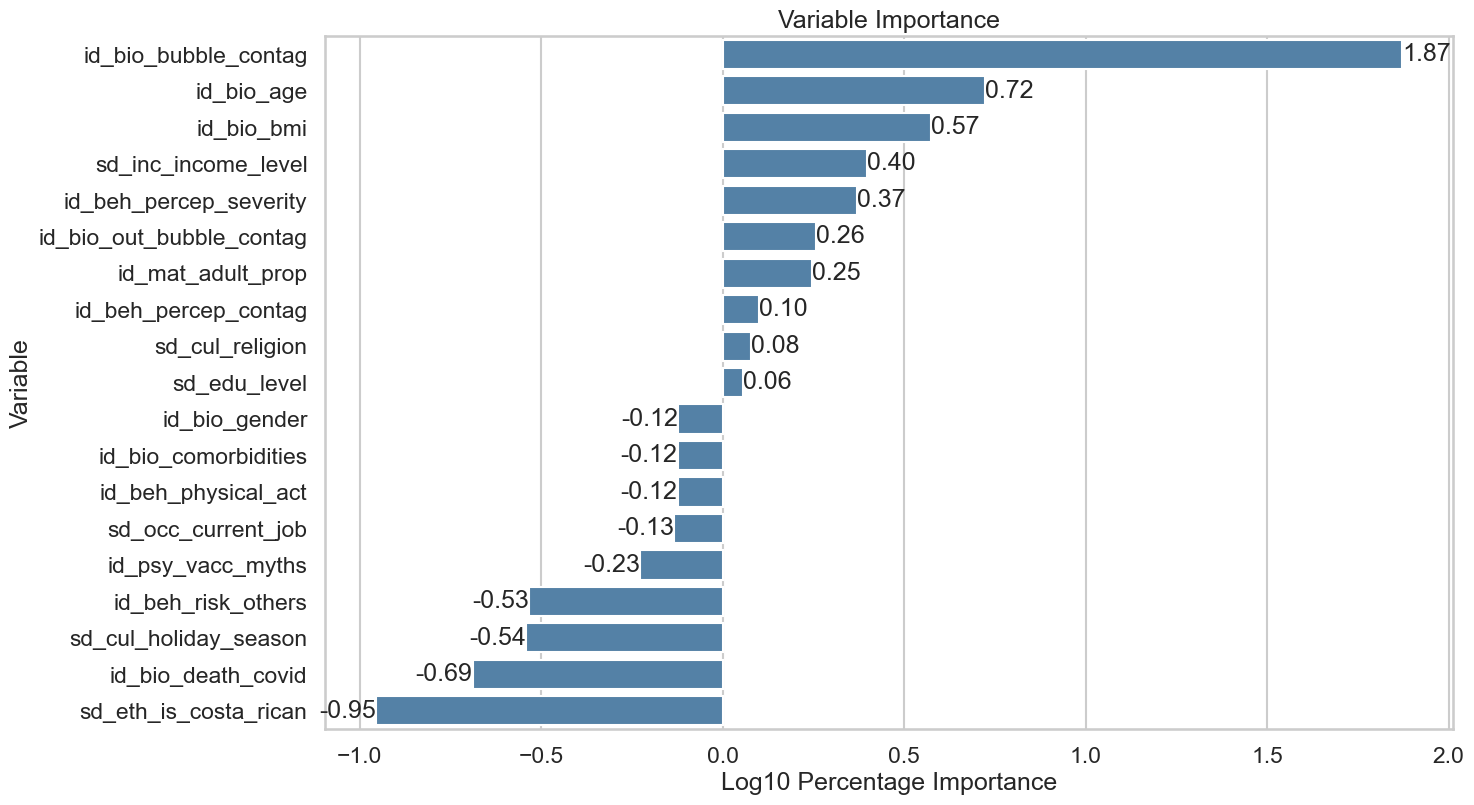

In [166]:
# Get variable importance data
var_imp = aml_leader.varimp(use_pandas=True)

# Filter only the variables with positive scaled_importance value
var_imp = var_imp[var_imp["percentage"] > 0]
var_imp["log_scaled_importance"] = np.log10(var_imp["percentage"] * 100)

h = 9
w = h * 1.618
# Create plot using seaborn
sns.set(style="whitegrid")
sns.set_context("talk")
plt.figure(figsize=(w, h))  # set the figure size
ax = sns.barplot(
    x="log_scaled_importance", y="variable", data=var_imp, color="steelblue"
)
ax.bar_label(ax.containers[0], fmt="%.2f")

# Set informative labels for the plot
plt.title("Variable Importance")
plt.xlabel("Log10 Percentage Importance")
plt.ylabel("Variable")

# Set the x-axis limits to adjust the scale
# plt.xlim(0, 1)

# Save plot to pdf file
plt.savefig("img/plot_var_imp.pdf", bbox_inches="tight")
plt.show()

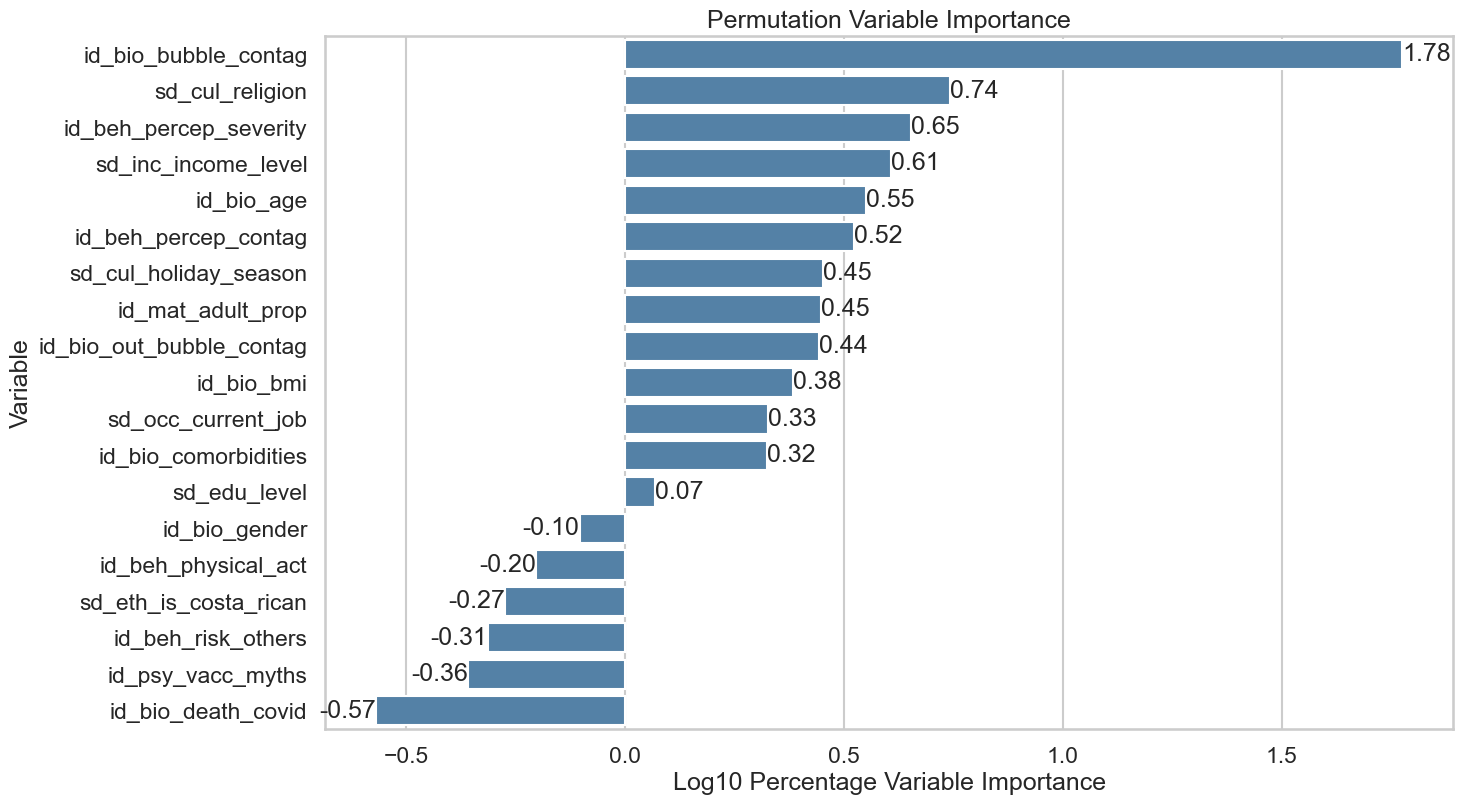

In [167]:
perm_imp = aml_leader.permutation_importance(
    frame=test_h2o, n_repeats=100, metric="PR_AUC", seed=42
)
perm_imp = perm_imp.as_data_frame()
perm_imp["mean"] = perm_imp[perm_imp.columns[1:]].mean(axis=1)
perm_imp = perm_imp.sort_values(by="mean", ascending=False)
perm_imp["Scaled Importance"] = perm_imp["mean"] / perm_imp["mean"].sum()

# perm_imp = perm_imp.as_data_frame()
perm_imp = perm_imp[perm_imp["Scaled Importance"] > 0]
perm_imp["log_scaled_importance"] = np.log10(perm_imp["Scaled Importance"] * 100)

h = 9
w = h * 1.618
# Create plot using seaborn
sns.set(style="whitegrid")
sns.set_context("talk")
plt.figure(figsize=(w, h))  # set the figure size
ax = sns.barplot(
    x="log_scaled_importance", y="Variable", data=perm_imp, color="steelblue"
)
ax.bar_label(ax.containers[0], fmt="%.2f")

# Set informative labels for the plot
plt.title("Permutation Variable Importance")
plt.xlabel("Log10 Percentage Variable Importance")
plt.ylabel("Variable")

# Set the x-axis limits to adjust the scale
# plt.xlim(0, 1)

# Save plot to pdf file
plt.savefig("img/plot_perm_imp.pdf", bbox_inches="tight")
plt.show()

<Figure size 1456.2x900 with 0 Axes>

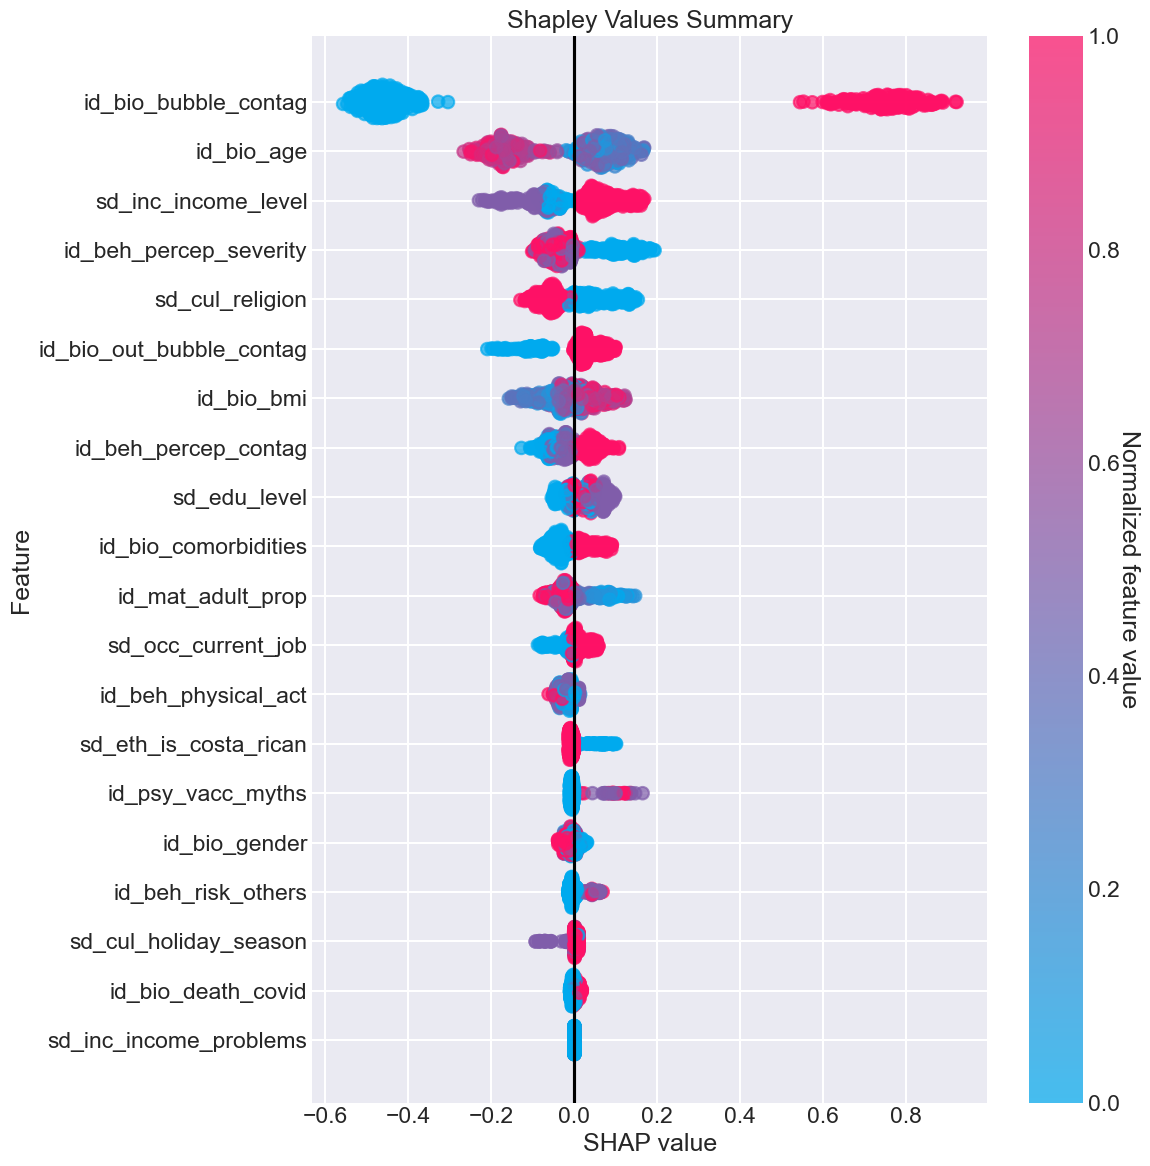

In [168]:
h = 9
w = h * 1.618

plt.style.use("seaborn-v0_8-dark")
plt.figure(figsize=(w, h))  # set the figure size


shap_plot = aml_leader.shap_summary_plot(test_h2o, alpha=0.7)
plt.rcParams.update({"font.size": 30})

plt.title("Shapley Values Summary")
plt.savefig("img/plot_shap.pdf", bbox_inches="tight")


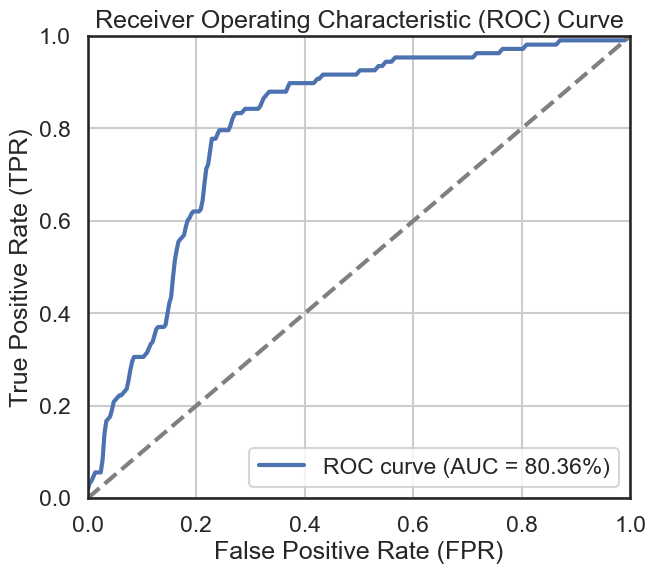

In [169]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc

matplotlib.style.use("default")

fprs = perf.fprs
tprs = perf.tprs
auc = perf.auc()

df = pd.DataFrame({"fpr": fprs, "tpr": tprs})
# increase font size

sns.set_theme(style="white")
sns.set_context("talk")
plt.figure(figsize=(7, 6))
sns.lineplot(
    x="fpr",
    y="tpr",
    lw=3,
    data=df,
    err_style=None,
    label="ROC curve (AUC = {:.2%})".format(auc),
)
plt.plot([0, 1], [0, 1], color="gray", lw=3, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("img/plot_roc.pdf", bbox_inches="tight")

plt.show()

In [170]:
precision = perf.precision(thresholds="all")
recall = perf.recall(thresholds="all")
pr_auc = perf.pr_auc()

precision = [t[1] for t in precision]
recall = [t[1] for t in recall]

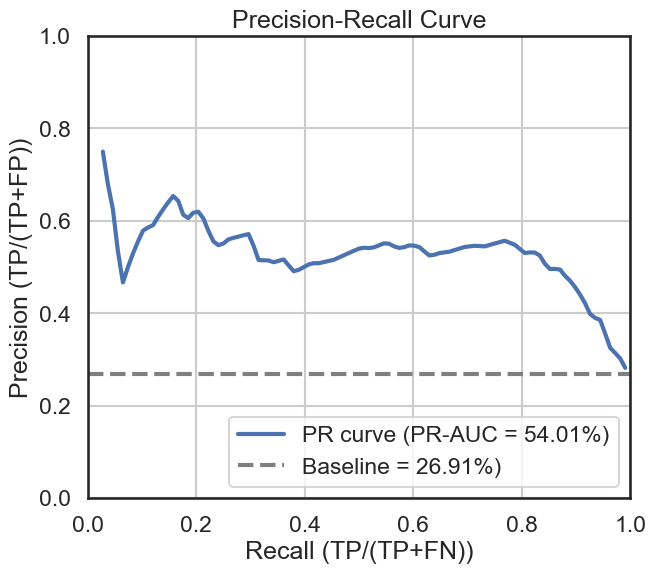

In [171]:
import seaborn as sns
import pandas as pd

precision = perf.precision(thresholds="all")
recall = perf.recall(thresholds="all")
pr_auc = perf.pr_auc()

precision = [t[1] for t in precision]
recall = [t[1] for t in recall]

df = pd.DataFrame({"Recall": recall, "Precision": precision})

df = df.query("Recall >0 & Recall < 1 & Precision >0 & Precision < 1")

sns.set_theme(style="white")
sns.set_context("talk")
plt.figure(figsize=(7, 6))
sns.lineplot(
    x="Recall",
    y="Precision",
    lw=3,
    data=df,
    err_style=None,
    label="PR curve (PR-AUC = {:.2%})".format(pr_auc),
)
plt.plot(
    [0, 1],
    [prevalence, prevalence],
    color="gray",
    lw=3,
    linestyle="--",
    label="Baseline = {:.2%})".format(prevalence),
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("Recall (TP/(TP+FN))")
plt.ylabel("Precision (TP/(TP+FP))")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("img/plot_pr.pdf", bbox_inches="tight")
plt.show()

In [172]:
# Variable importance
aml_leader.varimp(use_pandas=True)


,variable,relative_importance,scaled_importance,percentage
0,id_bio_bubble_contag,254.322464,1.000000,0.744939
1,id_bio_age,18.013647,0.070830,0.052764
2,id_bio_bmi,12.790842,0.050294,0.037466
3,sd_inc_income_level,8.541286,0.033584,0.025018
4,id_beh_percep_severity,7.989045,0.031413,0.023401
5,id_bio_out_bubble_contag,6.174971,0.024280,0.018087
6,id_mat_adult_prop,6.011201,0.023636,0.017607
7,id_beh_percep_contag,4.299047,0.016904,0.012592
8,sd_cul_religion,4.087945,0.016074,0.011974
9,sd_edu_level,3.882416,0.015266,0.011372


In [173]:
# Permutation importance
aml_leader.permutation_importance(
    frame=test_h2o, n_repeats=5, metric="PR_AUC", use_pandas=True
)


,Run 1,Run 2,Run 3,Run 4,Run 5
Variable,,,,,
id_bio_bubble_contag,0.232834,0.263501,0.227493,0.233439,0.245703
id_bio_age,0.028284,0.065196,0.011294,0.013535,0.001918
id_beh_percep_severity,0.025378,0.012167,0.009863,0.017398,0.029096
sd_cul_religion,0.015879,0.003940,0.014656,0.003362,0.001435
id_beh_percep_contag,0.014232,0.011628,0.000637,0.001237,0.000318
sd_cul_holiday_season,0.013898,0.008505,0.007149,0.008358,0.009772
id_mat_adult_prop,0.013729,0.008472,0.000100,0.002545,0.006453
sd_edu_level,0.007179,0.002639,0.000200,0.009998,0.004069
sd_occ_current_job,0.005289,0.015997,0.003060,0.023260,0.002468


Cálculo sin burbuja

In [174]:
# Guardar parametros
model_parameters = pd.DataFrame(
    {
        "prevalence": [prevalence],
        "threshold": [threshold],
        "sens_model": sensitivity,
        "spec_model": specificity,
        "people": test_h2o.nrow,
    }
)
print(model_parameters)
model_parameters.to_pickle(path="data/model_parameters.pkl")


   prevalence  threshold  sens_model  spec_model  people
0    0.269096   0.303679    0.796296    0.761092     401
